# Paying off a mortgage

Let's build a model for a 25 year 127500K mortgage structured with a monthly payment and an annual interest rate of 3.9 percent. For an added twist, I’m going to build the solution with an extra 500/month to pay down the principal more quickly.

In [43]:
# import modules

%autosave 30


import pandas as pd
from datetime import date
import numpy as np
from collections import OrderedDict
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

Autosaving every 30 seconds


Build a payment schedule using a generator that can be easily read into a pandas dataframe for additional analysis and plotting

In [44]:
def amortize(principal, interest_rate, years, pmt, addl_principal, start_date, annual_payments):
    """
    Calculate the amortization schedule given the loan details.

    :param principal: Amount borrowed
    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    :param pmt: Payment amount per period
    :param addl_principal: Additional payments to be made each period.
    :param start_date: Start date for the loan.
    :param annual_payments: Number of payments in a year.

    :return: 
        schedule: Amortization schedule as an Ortdered Dictionary
    """

    # initialize the variables to keep track of the periods and running balances
    p = 1
    beg_balance = principal
    end_balance = principal
    
    while end_balance > 0:
        
        # Recalculate the interest based on the current balance
        interest = round(((interest_rate/annual_payments) * beg_balance), 2)
        
        # Determine payment based on whether or not this period will pay off the loan
        pmt = min(pmt, beg_balance + interest)
        principal = pmt - interest
        
        # Ensure additional payment gets adjusted if the loan is being paid off
        addl_principal = min(addl_principal, beg_balance - principal)
        end_balance = beg_balance - (principal + addl_principal)

        yield OrderedDict([('Month',start_date),
                           ('Period', p),
                           ('Begin Balance', beg_balance),
                           ('Payment', pmt),
                           ('Principal', principal),
                           ('Interest', interest),
                           ('Additional_Payment', addl_principal),
                           ('End Balance', end_balance)])
        
        # Increment the counter, balance and date
        p += 1
        start_date += relativedelta(months=1)
        beg_balance = end_balance

Wrapper function to call amortize.
This function primarily cleans up the table and provides summary stats so it is easy to compare various scenarios.

In [45]:
def amortization_table(principal, interest_rate, years,
                       addl_principal=0, annual_payments=12, start_date=date.today()):
    """
    Calculate the amortization schedule given the loan details as well as summary stats for the loan

    :param principal: Amount borrowed
    :param interest_rate: The annual interest rate for this loan
    :param years: Number of years for the loan
    
    :param annual_payments (optional): Number of payments in a year. DEfault 12.
    :param addl_principal (optional): Additional payments to be made each period. Default 0.
    :param start_date (optional): Start date. Default first of next month if none provided

    :return: 
        schedule: Amortization schedule as a pandas dataframe
        summary: Pandas dataframe that summarizes the payoff information
    """
    
    # Payment stays constant based on the original terms of the loan
    payment = -round(np.pmt(interest_rate/annual_payments, years*annual_payments, principal), 2)
    
    # Generate the schedule and order the resulting columns for convenience
    schedule = pd.DataFrame(amortize(principal, interest_rate, years, payment,
                                     addl_principal, start_date, annual_payments))
    schedule = schedule[["Period", "Month", "Begin Balance", "Payment", "Interest", 
                         "Principal", "Additional_Payment", "End Balance"]]
    
    # Convert to a datetime object to make subsequent calcs easier
    schedule["Month"] = pd.to_datetime(schedule["Month"])
    
    #Create a summary statistics table
    payoff_date = schedule["Month"].iloc[-1]
    stats = pd.Series([payoff_date, schedule["Period"].count(), interest_rate,
                       years, principal, payment, addl_principal,
                       schedule["Interest"].sum()],
                       index=["Payoff Date", "Num Payments", "Interest Rate", "Years", "Principal",
                             "Payment", "Additional Payment", "Total Interest"])
    
    return schedule, stats

# Running the function

In [46]:
# run and look at the stats

df, stats = amortization_table(127500, .039, 25, addl_principal=500, start_date=date(2015, 3,18))
stats

Payoff Date           2026-06-18 00:00:00
Num Payments                          136
Interest Rate                       0.039
Years                                  25
Principal                          127500
Payment                            665.97
Additional Payment                    500
Total Interest                    30291.7
dtype: object

In [48]:
#check the first rows
df.head()

,Period,Month,Begin Balance,Payment,Interest,Principal,Additional_Payment,End Balance
0,1,2015-03-18,127500.00,665.97,414.38,251.59,500.0,126748.41
1,2,2015-04-18,126748.41,665.97,411.93,254.04,500.0,125994.37
2,3,2015-05-18,125994.37,665.97,409.48,256.49,500.0,125237.88
3,4,2015-06-18,125237.88,665.97,407.02,258.95,500.0,124478.93
4,5,2015-07-18,124478.93,665.97,404.56,261.41,500.0,123717.52


In [49]:
#check the last
df.tail()

,Period,Month,Begin Balance,Payment,Interest,Principal,Additional_Payment,End Balance
131,132,2026-02-18,5005.79,665.97,16.27,649.70,500.0,3856.09
132,133,2026-03-18,3856.09,665.97,12.53,653.44,500.0,2702.65
133,134,2026-04-18,2702.65,665.97,8.78,657.19,500.0,1545.46
134,135,2026-05-18,1545.46,665.97,5.02,660.95,500.0,384.51
135,136,2026-06-18,384.51,385.76,1.25,384.51,0.0,0.00


Make multiple calls to compare scenarios

In [51]:
schedule1, stats1 = amortization_table(127500, .039, 25, addl_principal=500, start_date=date(2015,3,18))
schedule2, stats2 = amortization_table(127500, .039, 25, addl_principal=200, start_date=date(2015,3,18))
schedule3, stats3 = amortization_table(127500, .039, 15, addl_principal=0, start_date=date(2015,3,18))

pd.DataFrame([stats1, stats2, stats3])

,Payoff Date,Num Payments,Interest Rate,Years,Principal,Payment,Additional Payment,Total Interest
0,2026-06-18,136,0.039,25,127500,665.97,500,30291.71
1,2031-11-18,201,0.039,25,127500,665.97,200,46259.73
2,2030-02-18,180,0.039,15,127500,936.73,0,41110.41


# Examples of plotting the data

Make some plots to show scenarios

In [52]:
%matplotlib inline
plt.style.use('ggplot')

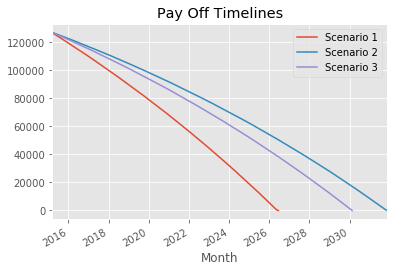

In [53]:
fig, ax = plt.subplots(1, 1)
schedule1.plot(x='Month', y='End Balance', label="Scenario 1", ax=ax)
schedule2.plot(x='Month', y='End Balance', label="Scenario 2", ax=ax)
schedule3.plot(x='Month', y='End Balance', label="Scenario 3", ax=ax)
plt.title("Pay Off Timelines");

In [54]:
def make_plot_data(schedule, stats):
    """Create a dataframe with annual interest totals, and a descriptive label"""
    y = schedule.set_index('Month')['Interest'].resample("A").sum().reset_index()
    y["Year"] = y["Month"].dt.year
    y.set_index('Year', inplace=True)
    y.drop('Month', 1, inplace=True)
    label="{} years at {}% with additional payment of ${}".format(stats['Years'], stats['Interest Rate']*100, stats['Additional Payment'])
    return y, label
    
y1, label1 = make_plot_data(schedule1, stats1)
y2, label2 = make_plot_data(schedule2, stats2)
y3, label3 = make_plot_data(schedule3, stats3)

y = pd.concat([y1, y2, y3], axis=1)

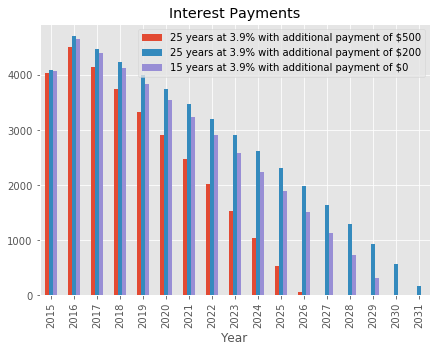

In [55]:
figsize(7,5)
fig, ax = plt.subplots(1, 1)
y.plot(kind="bar", ax=ax)

plt.legend([label1, label2, label3], loc=1, prop={'size':10})
plt.title("Interest Payments");

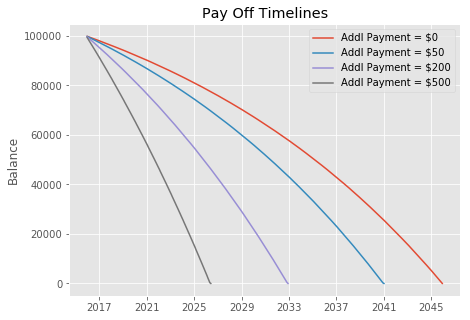

In [56]:
additional_payments = [0, 50, 200, 500]
fig, ax = plt.subplots(1, 1)

for pmt in additional_payments:
    result, _ = amortization_table(100000, .04, 30, addl_principal=pmt, start_date=date(2016,1,1))
    ax.plot(result['Month'], result['End Balance'], label='Addl Payment = ${}'.format(str(pmt)))
plt.title("Pay Off Timelines")
plt.ylabel("Balance")
ax.legend();